In [18]:
# import pandas as pd
# import tensorflow as tf
# import random
# import skimage.io as io
# import math
# from os import remove
# from PIL import Image 
# from keras.layers import Dense
# from keras import Model
# from keras import optimizers
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense
# from tensorflow.keras import Model
# from tensorflow.keras import optimizers
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tauthensorflow.keras.applications.vgg16 import VGG16
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelBinarizer
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.layers import Dense #, Input, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import NASNetMobile
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# from tensorflow.keras.optimizers import *
# import time
import tensorflow as tf
import glob
from sputum_detection_model import SputumDetectionModel
from keras.models import load_model
import cv2 #cv2 requiered for selective search on images
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
%cd ml-models/

/Users/simon/Documents/Projects/TFM/ml-models


In [13]:
# load the model
model_final = load_model('sputum_detector/models/rcnn_MNasNet_2.h5')
model = SputumDetectionModel(model_final, chunk_size=80, stride=40, verbose=True)
# load the image
images_path = glob.glob('sputum_detector/data/tuberculosis-phonecamera/*.jpg')
# images_path.sort()
img = cv2.cvtColor(cv2.imread(images_path[0]), cv2.COLOR_BGR2RGB)
img_cuts, chunks = model.preprocess_img(img)


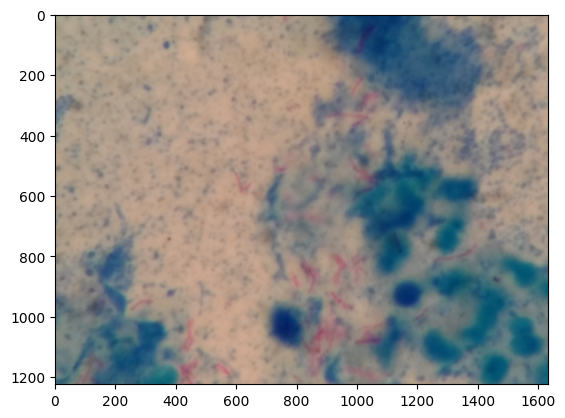

In [15]:
plt.imshow(img)

2023-06-27 15:38:59.186662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 15s 209ms/step
Objects found:  21


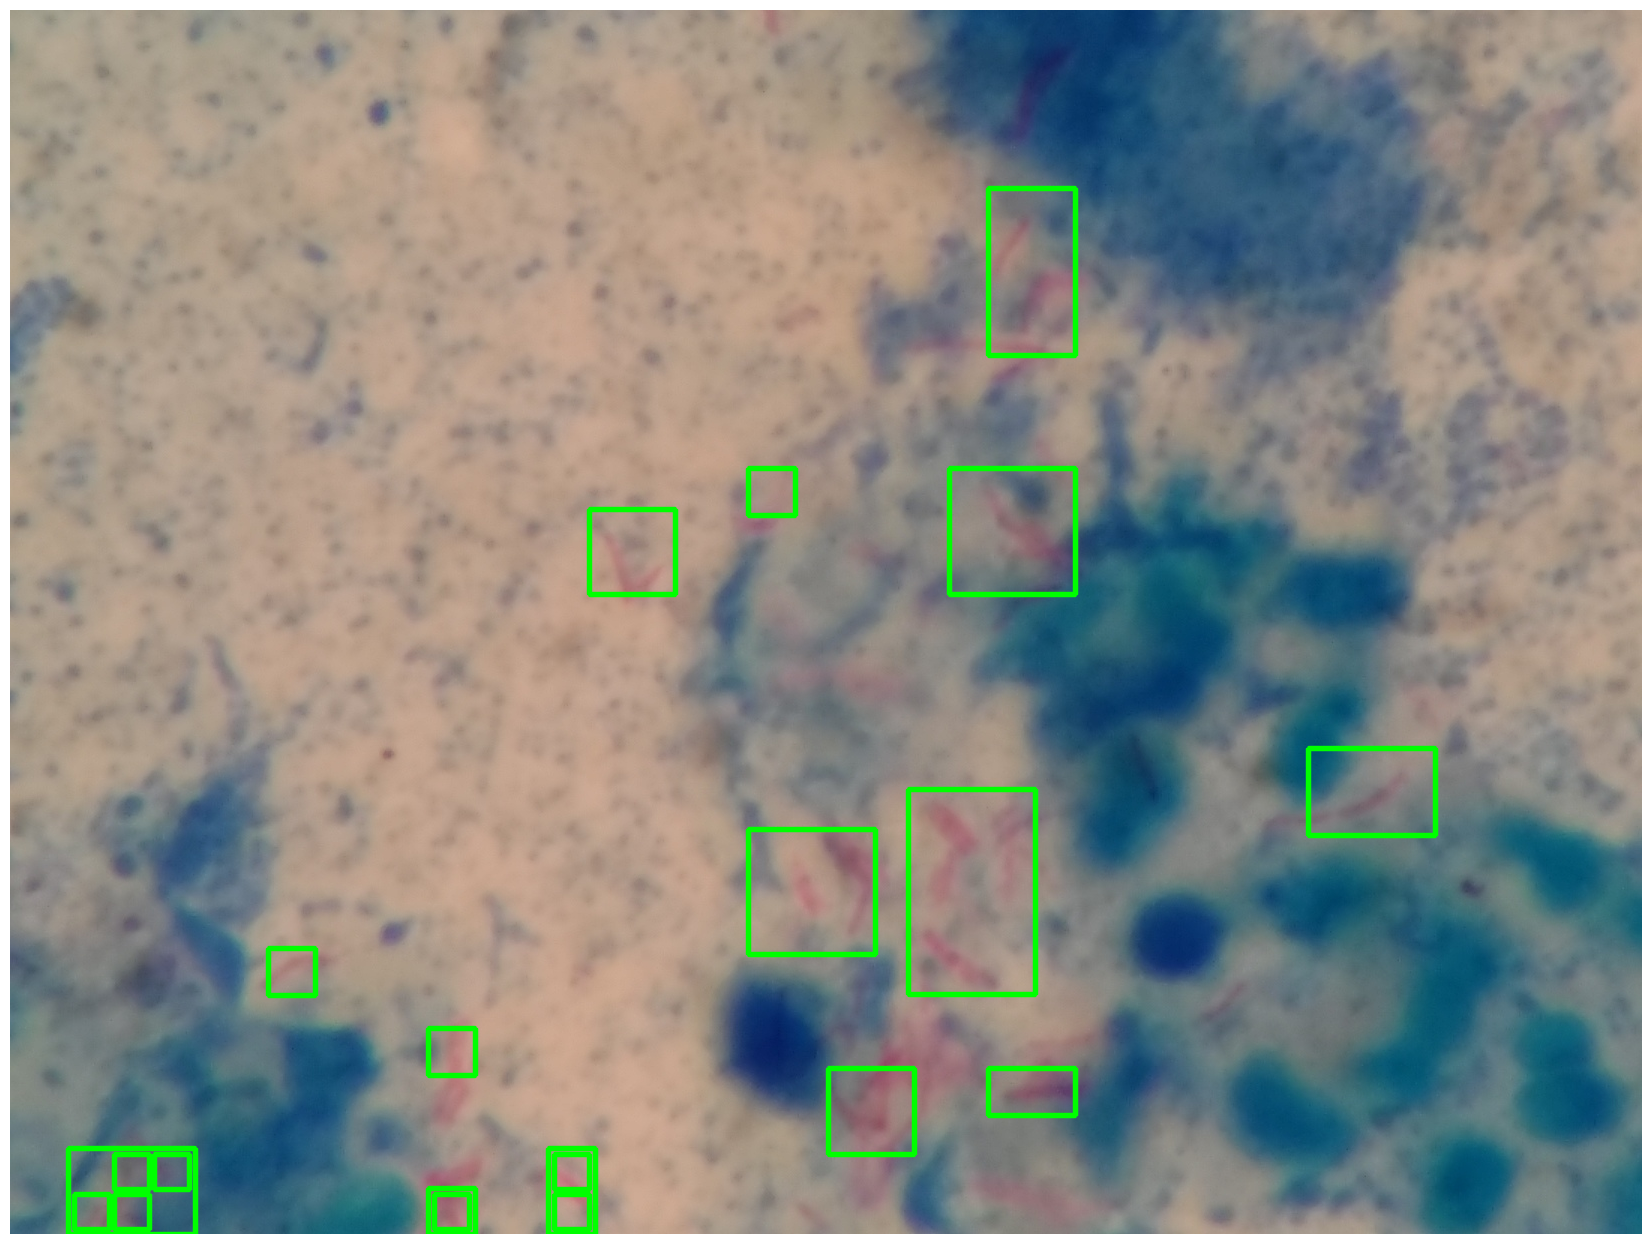

In [16]:
out = model.predict(img)
model.visualize_prediction(img, *out)

In [19]:
import mlflow
from mlflow.keras import log_model
mlflow.set_tracking_uri("http://127.0.0.1:9999")
mlflow.set_experiment("sputum_detection")
model_signature = mlflow.models.signature.infer_signature(
    img,
    np.array(model.predict_bbox(img))
)
reqs = ["tensorflow", "keras", "opencv-python", "numpy", "mlflow<3", "cloudpickle", "requests", "packaging"]
log_model(model_final, "sputum_detection_model", pip_requirements=reqs, signature=model_signature)

38/38 [==============================] - 5s 83ms/step


INFO:tensorflow:Assets written to: /var/folders/jj/p12jwj113hv_73vsjrcjcw040000gn/T/tmpjprgx7ib/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/jj/p12jwj113hv_73vsjrcjcw040000gn/T/tmpjprgx7ib/model/data/model/assets


In [20]:
mlflow.end_run()

: 

In [28]:
out = model.predict_bbox(img)

14/14 [==============================] - 2s 134ms/step


In [30]:
# save to the model repository (MLflow server)
import mlflow
from mlflow.keras import log_model
from sputum_detection_model import SputumDetectorPyfunc

model_signature = mlflow.models.signature.infer_signature(img, np.array(model.predict_bbox(img)))

mlflow.set_tracking_uri("http://127.0.0.1:9999")
mlflow.set_experiment("sputum_detection")

# run = mlflow.start_run()
reqs = ["tensorflow", "keras", "opencv-python", "numpy", "mlflow<3", "cloudpickle", "requests", "packaging"]
with mlflow.start_run(run_name="sputum_detection-model") as run:
    artifacts = {"model": "sputum_detection/models/rcnn_MNasNet_2.h5"}
    logged_model = mlflow.pyfunc.log_model(
        "sputum_model", 
        python_model=SputumDetectorPyfunc(chunk_size=80, stride=40, verbose=True),
        input_example=img,
        artifacts=artifacts,
        signature=model_signature,
        code_path=["sputum_detection/sputum_detection_model.py"],
        # conda_env={"channels": ["defaults", "conda-forge"], "dependencies": reqs},
        pip_requirements=reqs
    )
    mlflow.log_param("chunk_size", 80)
    mlflow.log_param("stride", 40)
    mlflow.log_param("verbose", False)
    mlflow.log_param("model", "rcnn_MNasNet_2.h5")
    mlflow.log_param("model_type", "rcnn")
    mlflow.log_param("backbone", "MNasNet")

14/14 [==============================] - 2s 97ms/step


In [5]:
# register model to mlflow
client = mlflow.tracking.MlflowClient()

reg_model = mlflow.register_model(
    "runs:/{}/sputum_model".format(run.info.run_id), 
    name="sputum_detector",
    # description="Sputum detector model: This model detects sputum in images, and returns the bounding boxes of the sputum regions.",
    tags={"chunk_size": 80, "stride": 40, "verbose": False, "model": "rcnn_MNasNet_2.h5", "model_type": "rcnn", "backbone": "MNasNet"},
)

client.update_model_version(
    name="sputum_detector",
    version=reg_model.version,
    description="Sputum detector model: This model detects sputum in images, and returns the bounding boxes of the detected regions.",
)

client.transition_model_version_stage(
    name="sputum_detector",
    version=reg_model.version,
    stage="Staging",
)

Registered model 'sputum_detector' already exists. Creating a new version of this model...
2023/05/26 13:51:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: sputum_detector, version 21
Created version '21' of model 'sputum_detector'.


<ModelVersion: creation_timestamp=1685101883455, current_stage='Staging', description=('Sputum detector model: This model detects sputum in images, and returns the '
 'bounding boxes of the detected regions.'), last_updated_timestamp=1685101886430, name='sputum_detector', run_id='d5a1a2deda0f4bd4a5eeb2388baa7142', run_link='', source='mlflow-artifacts:/475493153802588967/d5a1a2deda0f4bd4a5eeb2388baa7142/artifacts/sputum_model', status='READY', status_message='', tags={'backbone': 'MNasNet',
 'chunk_size': '80',
 'model': 'rcnn_MNasNet_2.h5',
 'model_type': 'rcnn',
 'stride': '40',
 'verbose': 'False'}, user_id='', version='21'>

In [ ]:
# inference example
out, chunks = model.predict(img)
print(sum(out[:,0]>0.5), "chunks detected")
print("chunks has shape", chunks.shape)
new_img=model.visualize_prediction(img, out, chunks, asarray=False)

NameError: name 'model' is not defined

36/36 [==============================] - 11s 19ms/step


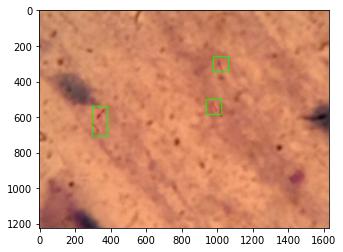

In [3]:
## MArcar solo los bordes
TestImage=[]
Coord=[]
filename='tuberculosis-phone-0031.jpg'
img = cv2.imread(f'./Data/Test/{filename}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
Minimo=img.min()

Maximo=img.max()

img= (((img - Minimo)/(Maximo-Minimo))*255)
img = img.astype(np.uint8)
imout = img.copy()



aumento=20
X1 = 23
X2 = 63
Y1 = 23
Y2 = 63 
flag = 0
while flag == 0:
    if X2>1584:
        X1 = 23
        X2 = 63
        Y1=Y1+40      
        Y2=Y2+40
        if Y2>1203:
            flag=1

    timage = imout[(Y1-aumento):(Y2+aumento),(X1-aumento):(X2+aumento)]
    #timage = imout[Y1:Y2,X1:X2]
    resized = cv2.resize(timage, (80,80), interpolation = cv2.INTER_NEAREST)
    #resized=resized/255
    TestImage.append(resized)
    Coord.append((X1,Y1,X2,Y2))
    #img = np.expand_dims(resized, axis=0)
    X1=X1+40      
    X2=X2+40
TestImage_new = np.array(TestImage)/255
Coord_new = np.array(Coord)
TestImage_new.shape
model_final=load_model('rcnn_MNasNet_2.h5')
out= model_final.predict(TestImage_new, verbose=1)
imout=imout*0
for i in range(out.shape[0]) :
    
    if out[i][0] > 0.5:# and z<100: ## la clase 0 entendemos que esnodulo v## en el otro es el 1
        cv2.rectangle(imout, (Coord_new[i][0], Coord_new[i][1]), (Coord_new[i][2], Coord_new[i][3]), (0, 255, 0),3, cv2.LINE_AA)

gray = cv2.cvtColor(imout, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gray, 10, 150)

cnts,_ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)# OpenCV 4    
for c in cnts:
  epsilon = 0.01*cv2.arcLength(c,True)
  approx = cv2.approxPolyDP(c,epsilon,True)
  x,y,w,h = cv2.boundingRect(approx)

  cv2.rectangle(img, (int(x), int(y)), (int(x+w),int(y+h)), (0, 255, 0),3, cv2.LINE_AA)
plt.figure()
plt.imshow(img)
fin =time.time()